In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML

In [18]:
n_x =500


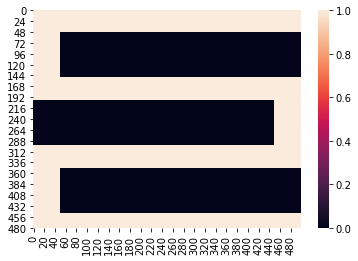

In [20]:
c0 = np.zeros((n_x,n_x))
c0[:50,:]=1
c0[50:150,:50]=1
c0[150:200,:]=1
c0[200:300,450:]=1
c0[300:350,:]=1
c0[350:450,:50]=1
c0[450:,:]=1
sns.heatmap(c0)

In [ ]:
c0 = c0.ravel()

In [51]:


import time
start_time = time.time()

#Coéfficients physiques
K=2#coefficient diffusion
b= .9# dtC=-b*rho*C
F0= 1 # dtRho = Fo*Mu

physique = [K,b,F0]

#Paramêtres numériques 
n_t=1000 #nombre de pas de temps
tf=500 # temps final de la simulation
xf = n_x #longueur de la simulation
yf = xf
n_y = n_x 
n_xy = n_x * n_y
numerique = [n_t,tf,xf,n_x,yf,n_y]

params = physique,numerique


#Données initiales 
rho0=np.zeros(n_xy) #rho initial	
mu0=np.zeros(n_xy)#mu initial
mu0[450]=.01

        
class EDP():
    def __init__(self,params):
        self.physique, self.numerique = params
        self.K,self.b,self.F0 = self.physique
        self.n_t,self.tf,self.xf,self.n_x,self.yf,self.n_y = self.numerique
        
        
        self.n_xy = self.n_x*self.n_y
        self.dt = self.tf/(self.n_t-1)
        self.dx = self.xf/(self.n_x-1)
        self.dy = self.yf/(self.n_y-1)
        
        #self.X = np.linspace(0,self.xf,self.n_x)
        #self.Y = np.linspace(0,self.yf,self.n_y)
        #self.T = np.linspace(0,self.tf,self.n_t)

        #Matrice du Laplacien
        self.Lapl = sp.diags(-4*np.ones(self.n_xy),0)
        #Lapl += sp.diags(np.ones(n_xy-1),1)+sp.diags(np.ones(n_xy-1),-1)
        diagmod = np.ones(self.n_xy-1)
        diagmod[np.arange(self.n_y-1,self.n_xy-1,self.n_y)] = np.zeros(self.n_y-1)
        self.Lapl += sp.diags(diagmod,1) + sp.diags(diagmod,-1)
        self.Lapl += sp.diags(np.ones(self.n_xy-self.n_y),self.n_y)+sp.diags(np.ones(self.n_xy-self.n_y),-self.n_y)
        self.Lapl = -self.K*self.dt/(self.dx**2)*self.Lapl
    def array_to_2D(n_x,vect):
        return np.array(np.split(vect,n_x))

    def integrate(self,initial):
        mu,rho,c = initial
        alpha=-c*self.dt*(1+self.dt*self.F0)+self.dt*rho+1
        A = self.Lapl + sp.diags(alpha,0)
        Target =  mu+self.dt*c*rho
        
        #next_mu = spsolve(A,Target) #95.28 secondes d'execution
        #next_mu,check = bicg(A,Target) #3.38 secondes d'execution
        #next_mu,check = bicgstab(A,Target, x0=mu) #2.15 secondes d'execution
        #next_mu,check = cg(A,Target) #2.29 secondes d'execution
        #next_mu,check = cgs(A,Target) #2.36 secondes d'execution
        #next_mu,check = gmres(A,Target) #2.72 secondes d'execution
        #next_mu,check = lgmres(A,Target) #2.62 secondes d'execution
        next_mu,check = minres(A,Target, x0=mu) #2.15 secondes d'execution
        #next_mu,check = qmr(A,Target) #3.70 secondes d'execution
        #next_mu,check = gcrotmk(A,Target) #2.62 secondes d'execution
        next_rho = rho + self.dt*self.F0*next_mu
        next_c = c/(1+self.b*self.dt*next_rho)
        return next_mu, next_rho, next_c
        
        
Agent = EDP(params)

mu= mu0
rho= rho0
c= c0
Mu=[mu0]
Rho=[rho0]
C=[c0]
n = 0
N_print = 100
n_print = 0
while n<n_t:
    mu,rho,c = Agent.integrate((mu,rho,c)) 
    mu[mu<1e-3]=0
    if n>n_print * n_t / N_print :
        n_print +=1
        Mu.append(mu)
        Rho.append(rho)
        C.append(c)
    if n % 25 ==0 :
        print(n, (time.time() - start_time))
    n+=1

print("--- %s seconds ---" % (time.time() - start_time))

tot = len(Mu)

0 0.4190502166748047
25 9.425578355789185
50 19.69554305076599
75 29.69096803665161
100 40.11172962188721
125 49.86189889907837
150 60.37518000602722
175 70.77278065681458
200 80.12032341957092
225 90.87768936157227
250 101.595046043396
275 110.89244508743286
300 119.73442459106445
325 128.67762184143066
350 138.50803685188293
375 147.1426501274109
400 156.68795728683472
425 166.052579164505
450 174.06012058258057
475 181.33213448524475
500 186.8732328414917
525 192.20886516571045
550 197.08904671669006
575 202.92984819412231
600 208.60018396377563
625 214.29709887504578
650 220.07036924362183
675 224.7051215171814
700 230.95211172103882
725 236.1753420829773
750 241.8675947189331
775 246.86031007766724
800 251.78686666488647
825 257.2812650203705
850 262.6938488483429
875 267.969144821167
900 273.74189019203186
925 278.8955132961273
950 284.1490116119385
975 289.5753490924835
--- 294.617475271225 seconds ---


In [52]:
data = []
for i in range(len(Rho)):
    data += [EDP.array_to_2D(n_x,Rho[i])]

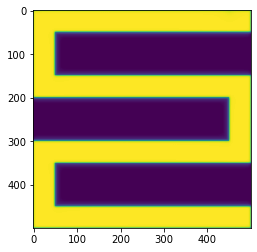

In [55]:
fig = plt.figure()
im = plt.imshow(data[100])
def init():
    im.set_array(data[100])
    return im,

def animate(i):
    im.set_array(data[i])
    return im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=50, repeat = False)

In [56]:
HTML(anim.to_jshtml())

In [57]:
anim.save('tube2.mp4', writer='ffmpeg')